In [82]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVR
import xgboost as xgb

In [2]:
data = pd.read_csv("ExecutionAlgoData.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,11,14,15,16,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.shape

(69212, 29)

In [4]:
data.dropna(inplace=True)
data.drop(['BTP_PlacementID'],axis=1,inplace=True)

In [5]:
i=0
while i < 3:
    if i == 0:
        data['BTP_TradeDateEST_day'] = pd.to_datetime(data['BTP_TradeDateEST']).dt.day
    elif i == 1:
        data['BTP_TradeDateEST_month'] = pd.to_datetime(data['BTP_TradeDateEST']).dt.month
    else:
        data['BTP_TradeDateEST_year'] = pd.to_datetime(data['BTP_TradeDateEST']).dt.year
    i += 1

In [6]:
data.drop(['BTP_TradeDateEST'],axis=1,inplace=True)

In [7]:
for col in ['BTP_Broker','BTP_Strategy','BTP_Desk','BTP_Trader','BTP_OrderType']:
    ohe = OneHotEncoder(sparse=False)
    x = pd.DataFrame(ohe.fit_transform(data[col].to_numpy().reshape(-1,1)))
    for cols in x.columns:
        data[col+'_ohe_'+str(cols)] = x[cols]
    #with open('models/one_hot_encoding_'+col+".bin","wb") as f:
        #pickle.dump(ohe, f)
    data.drop([col],axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)

In [9]:
data['BTP_Side'] = data['BTP_Side'].apply(lambda a:int(a == 'S'))

In [10]:
i=0
t1 = pd.to_datetime(data['BTP_StartTime'])
while i < 6:
    if i == 0:
        data['BTP_StartTime_day'] = t1.dt.day
    elif i == 1:
        data['BTP_StartTime_month'] = t1.dt.month
    elif i == 2:
        data['BTP_StartTime_year'] = t1.dt.year
    elif i == 3:
        data['BTP_StartTime_hour'] = t1.dt.hour
    elif i == 4:
        data['BTP_StartTime_minute'] = t1.dt.minute
    else:
        data['BTP_StartTime_second'] = t1.dt.second
    i += 1
data.drop(['BTP_StartTime'],axis=1,inplace=True)

In [11]:
data.shape

(33485, 131)

In [12]:
(data.dtypes == 'float64').sum(), (data.dtypes == 'int64').sum(), (data.dtypes == 'object').sum()

(121, 10, 0)

In [13]:
x = data.drop(['BTP_LmtAdjArrivalPrice_bps','BTP_LmtAdjPWP20Pct_bps'],axis=1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,data.BTP_LmtAdjPWP20Pct_bps,test_size=0.15)

In [15]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)
#pickle.dump(scaler_x)

In [16]:
parameters = {
    'alpha' : [0.1, 0.25],
    'l1_ratio' : [0.6,0.8],
    'tol' : [0.0001, 0.00001],
}
models = GridSearchCV(ElasticNet(normalize=False),cv=4,verbose=1,param_grid=parameters)
models.fit(x_train_std,y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


GridSearchCV(cv=4, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 0.25], 'l1_ratio': [0.6, 0.8],
                         'tol': [0.0001, 1e-05]},
             verbose=1)

In [17]:
models.best_estimator_.score(x_train_std,y_train), models.best_estimator_.score(x_test_std,y_test)

(0.25697014635831994, 0.25482843363925156)

<AxesSubplot:xlabel='features'>

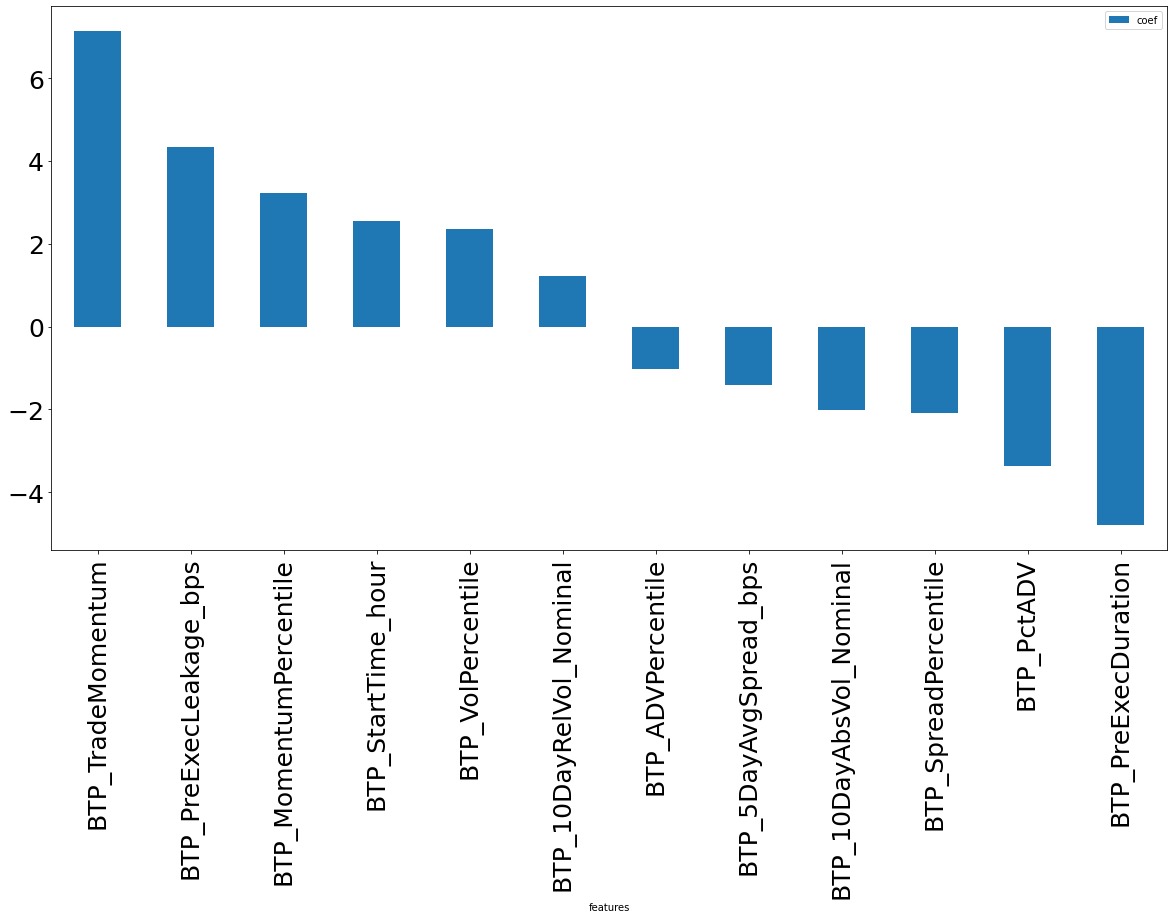

In [18]:
t1 = pd.DataFrame(models.best_estimator_.coef_,columns = ['coef'])
t1['features'] = x_train.columns

t1 = t1.loc[abs(t1.coef)>1]
t1.sort_values(['coef'],ascending=False).plot('features','coef',kind='bar',figsize=(20, 10),fontsize=25)

In [19]:
#models.best_estimator_.get_params()

In [42]:
parameters = {
    'epsilon' : [1,2],
    'C' : [1,2],
}
models = GridSearchCV(LinearSVR(max_iter=500,tol=0.0005),cv=3,verbose=3,param_grid=parameters)
models.fit(x_train_std,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/3] END .................................C=1, epsilon=1; total time=   6.7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/3] END .................................C=1, epsilon=1; total time=   6.4s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/3] END .................................C=1, epsilon=1; total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/3] END .................................C=1, epsilon=2; total time=   6.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/3] END .................................C=1, epsilon=2; total time=   6.3s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/3] END .................................C=1, epsilon=2; total time=   6.6s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/3] END .................................C=2, epsilon=1; total time=   6.8s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/3] END .................................C=2, epsilon=1; total time=   7.2s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/3] END .................................C=2, epsilon=1; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 1/3] END .................................C=2, epsilon=2; total time=   6.9s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 2/3] END .................................C=2, epsilon=2; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV 3/3] END .................................C=2, epsilon=2; total time=   7.0s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVR(max_iter=500, tol=0.0005),
             param_grid={'C': [1, 2], 'epsilon': [1, 2]}, verbose=3)

In [43]:
models.best_estimator_.get_params()

{'C': 2,
 'dual': True,
 'epsilon': 2,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'loss': 'epsilon_insensitive',
 'max_iter': 500,
 'random_state': None,
 'tol': 0.0005,
 'verbose': 0}

In [44]:
models.best_estimator_.score(x_train_std,y_train), models.best_estimator_.score(x_test_std,y_test)

(0.15271002834077296, 0.1479504742825991)

<AxesSubplot:xlabel='features'>

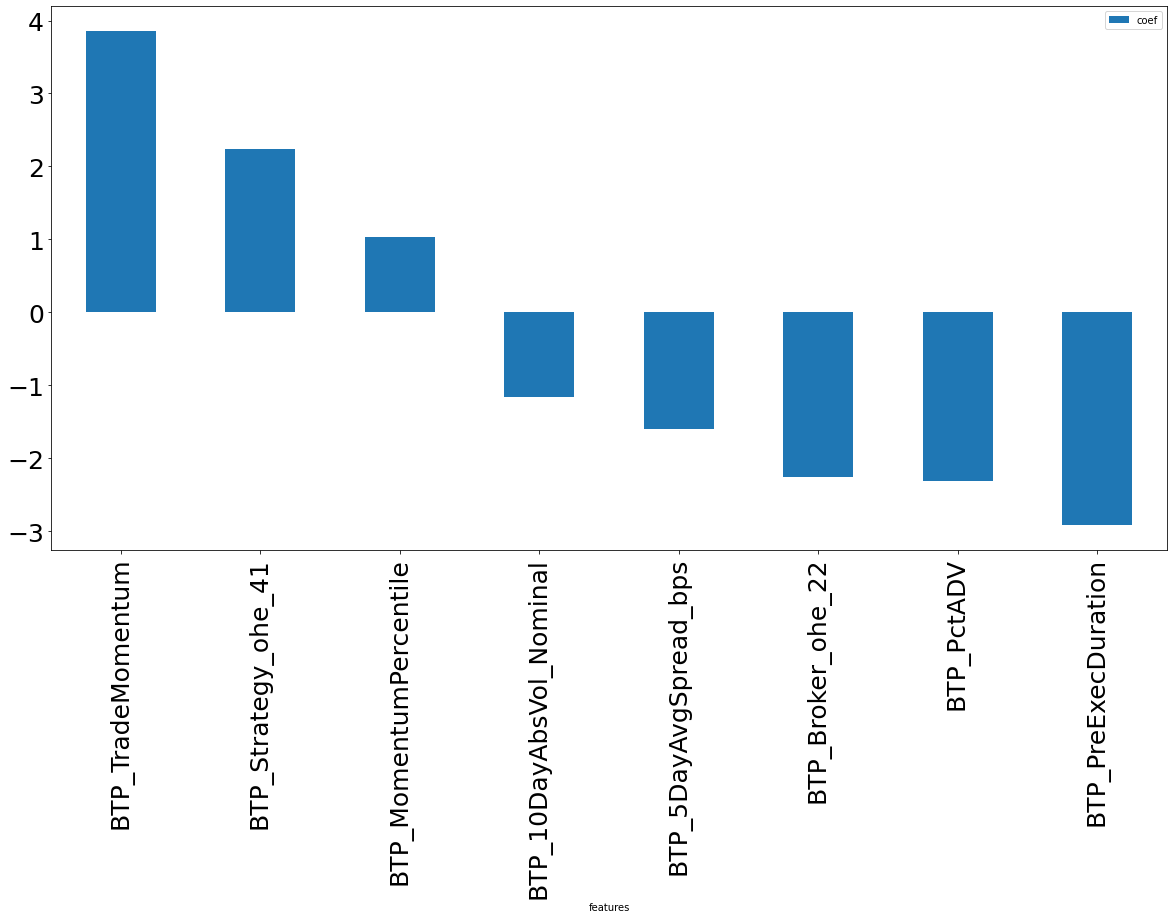

In [45]:
t1 = pd.DataFrame(models.best_estimator_.coef_,columns = ['coef'])
t1['features'] = x_train.columns

t1 = t1.loc[abs(t1.coef)>1]
t1.sort_values(['coef'],ascending=False).plot('features','coef',kind='bar',figsize=(20, 10),fontsize=25)

In [88]:
xgb_algo = xgb.XGBRegressor(gamma=1,booster='gbtree')
xgb_algo.fit(x_train_std,y_train)
xgb_algo.score(x_train_std,y_train),xgb_algo.score(x_test_std,y_test)

(0.9054527475040801, 0.5210125613340388)

In [ ]:
parameters = {
    'booster' : ['gbtree','dart'],
    'max_depth' : [4,5],
    'lambda' : [0.5,1],
    'alpha' : [0.5,1],
}
models = GridSearchCV(xgb.XGBRegressor(),cv=3,verbose=3,param_grid=parameters)
models.fit(x_train_std,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END alpha=0.5, booster=gbtree, lambda=0.5, max_depth=4; total time=   7.0s
[CV 2/3] END alpha=0.5, booster=gbtree, lambda=0.5, max_depth=4; total time=   7.6s
[CV 3/3] END alpha=0.5, booster=gbtree, lambda=0.5, max_depth=4; total time=   7.9s
[CV 1/3] END alpha=0.5, booster=gbtree, lambda=0.5, max_depth=5; total time=  10.6s
[CV 2/3] END alpha=0.5, booster=gbtree, lambda=0.5, max_depth=5; total time=  10.1s
[CV 3/3] END alpha=0.5, booster=gbtree, lambda=0.5, max_depth=5; total time=  10.6s
[CV 1/3] END alpha=0.5, booster=gbtree, lambda=1, max_depth=4; total time=   7.7s
[CV 2/3] END alpha=0.5, booster=gbtree, lambda=1, max_depth=4; total time=   7.3s
[CV 3/3] END alpha=0.5, booster=gbtree, lambda=1, max_depth=4; total time=   7.3s
[CV 1/3] END alpha=0.5, booster=gbtree, lambda=1, max_depth=5; total time=   8.9s
[CV 2/3] END alpha=0.5, booster=gbtree, lambda=1, max_depth=5; total time=   9.7s
[CV 3/3] END alpha=0.5, b

In [ ]:
models.best_estimator_.get_params()

In [ ]:
models.best_estimator_.score(x_train_std,y_train), models.best_estimator_.score(x_test_std,y_test)

In [ ]:
t1.sort_values(['coef'],ascending=False).plot('features','coef',kind='bar',figsize=(20, 10),fontsize=25)